# Projeto Redes Neurais 2023.1 - Dados
## Aluno: Marcel Pinheiro Caraciolo
## Problema: Classificação de equipes de F1 baseado nas imagens do carros

## Importando as bibliotecas

In [2]:
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.core.display import HTML,display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from shutil import copyfile
from PIL import Image

## Pré-processamento de dados

### Download dos Dados

In [4]:
!curl -L "https://app.roboflow.com/ds/e6AamRvuma?key=qTdASZMqGb" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd /content/
%mkdir images/
%mv train images/train
%mv test images/test


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0   2710      0 --:--:-- --:--:-- --:--:--  2709
100 19.7M  100 19.7M    0     0  23.5M      0 --:--:-- --:--:-- --:--:-- 23.5M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
   creating: test/alfaromeo/
 extracting: test/alfaromeo/alfaromeo_10_jpg.rf.dbcb72e7c565c9dcaec7f39b2a415627.jpg  
 extracting: test/alfaromeo/alfaromeo_32_jpg.rf.ea917c76c7cfa8829859412cd612e1d7.jpg  
 extracting: test/alfaromeo/alfaromeo_51_jpg.rf.ed34d3895c46def4eff5a3b0274520c6.jpg  
 extracting: test/alfaromeo/alfaromeo_5_jpg.rf.2877e6ec2a2cc59bede1c2000b93416a.jpg  
 extracting: test/alfaromeo/alfaromeo_74_jpg.rf.90cceac05dfb241ac52dc5a5e32b69db.jpg  
   creating: test/alphatauri/
 extracting: test/alphatauri/alphatauri_108_jpg.rf.70255c7f65c8e3a24db316

### Convertendo as imagens em Tensorflow ImageDatasets

In [5]:
train_dir='./images/train'
test_dir='./images/test'

In [6]:
IMAGE_SIZE=(224,224)

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False
)

class_names=train_data.class_names

# prefetching the datasets for faster training
train_data=train_data.prefetch(tf.data.AUTOTUNE)
test_data=test_data.prefetch(tf.data.AUTOTUNE)

Found 1947 files belonging to 10 classes.
Found 163 files belonging to 10 classes.


### Pré-visualizando dados


In [5]:
def plot_random_image(target_dir):
    """
    takes the directory as input and prints 5 random images from the randomly choosen class.
    """
    display(HTML('<H2 style="color:red"> <b>Data Visualization</b></H2><hr>'))
    target_class=random.choice(os.listdir(target_dir))
    target_folder=os.path.join(target_dir,target_class)
    random_image=random.sample(os.listdir(target_folder),6)
    plt.figure(figsize=(20,5))
    for i in range(6):

        plt.subplot(1,6,i+1)
        img=tf.io.read_file(os.path.join(target_folder,random_image[i]))
        img=tf.io.decode_image(img)
        img=tf.image.resize(img,(224,244))
        plt.imshow(img/255.0)
        plt.title(f'{target_class}\n{img.shape}',size=20)
        plt.xticks([]);
        plt.yticks([])
        plt.tight_layout()
    plt.show()
    display(HTML('<hr>'))

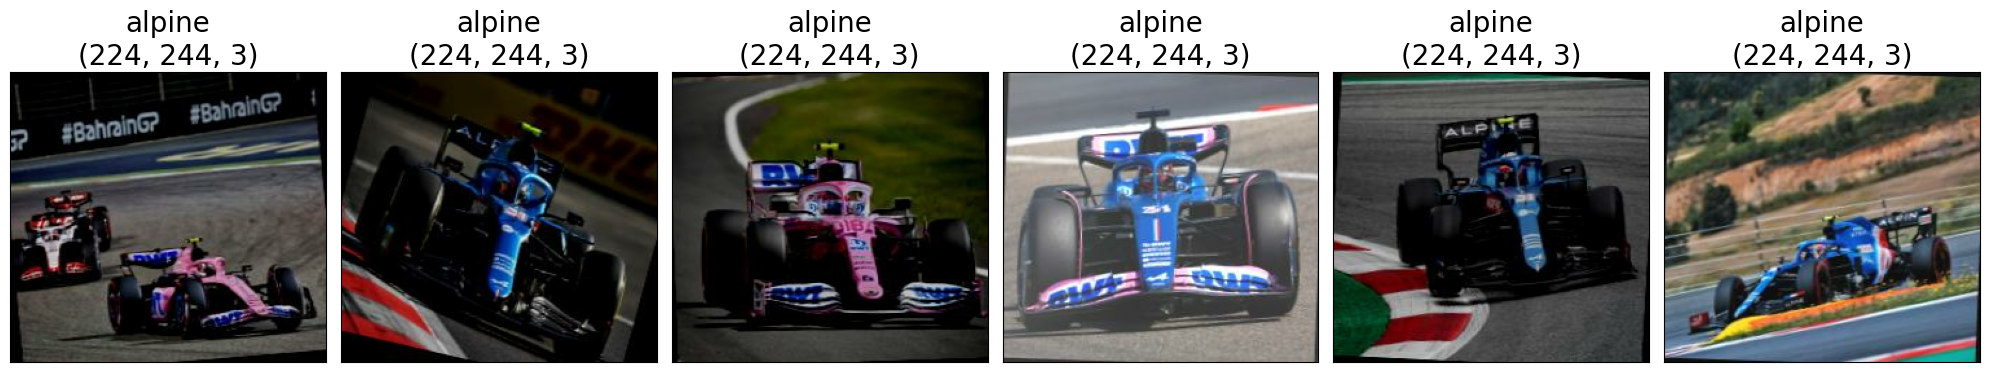

In [6]:
plot_random_image(train_dir)

In [7]:
print(class_names)

['alfaromeo', 'alphatauri', 'alpine', 'astonmartin', 'ferrari', 'haas', 'mclaren', 'mercedes', 'redbull', 'williams']


## Configurando o Modelo

Vamos usar como referência o modelo **EfficientNetB0** . A Escolha deste modelo foi empírica, baseado em estudar novos modelos para problemas de classificação.

In [8]:
mixed_precision.set_global_policy('mixed_float16')

inputs=layers.Input(shape=(224,224,3),name='input_layer')

base_model=keras.applications.efficientnet.EfficientNetB0(include_top=False, weights='imagenet')
base_model.trainable=False

x=base_model(inputs,training=False)

x=layers.GlobalAveragePooling2D(name='Global_Average_Pool_2D')(x)
num_classes=len(class_names)
outputs=layers.Dense(num_classes,activation='softmax',dtype=tf.float32,name="Output_layer")(x)

model=keras.Model(inputs,outputs,name="EfficientNet")

In [11]:
# to save the initial weights of the model
model.save_weights('initial_weights.ckpt')

In [12]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [13]:
model.summary()


Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 Global_Average_Pool_2D (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 Output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


## Treinando modelo (Feature Extraction)

In [14]:
# Weights & Biases  (optional)
%pip install -q wandb
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00


In [15]:
import sys

def wandb_colab_login():
  """Temporary hack to prevent colab from hanging"""
  sys.modules["google.colab2"] = sys.modules["google.colab"]
  del sys.modules["google.colab"]
  wandb.login()
  sys.modules["google.colab"] = sys.modules["google.colab2"]
wandb_colab_login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#### Callbacks
We will be using the following callbacks:

Kears ModelCheckpoint - using val_loss metric to save the best model weights  during the training.

WandbCallback - To monitor model performance and system metrics.

In [16]:
from wandb.keras import WandbCallback
wandb.init( project='f1-classification', job_type='train', name=f'efficientnet-b0')


wandb: Currently logged in as: marcelcaraciolo. Use `wandb login --relogin` to force relogin


In [17]:
def create_model_check_point_callback(checkpoint_path,monitor='val_loss'):
    """
    Takes the path where to save the best model weights obtained during training.
    """
    model_checkpoint_cb=tf.keras.callbacks.ModelCheckpoint(

        monitor=monitor,
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    )
    return model_checkpoint_cb

In [18]:
ModelCheckPoint_model_cb=create_model_check_point_callback('./ModelCheckPoints/model_1.ckpt')
EPOCHS=5
history_of_model_1=model.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[ModelCheckPoint_model_cb, WandbCallback()]
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/5
61/61 [==============================] - ETA: 0s - loss: 1.9079 - accuracy: 0.3770
Epoch 1: val_loss improved from inf to 1.73944, saving model to ./ModelCheckPoints/model_1.ckpt


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 48s 548ms/step - loss: 1.9079 - accuracy: 0.3770 - val_loss: 1.7394 - val_accuracy: 0.4417
Epoch 2/5
60/61 [============================>.] - ETA: 0s - loss: 1.2348 - accuracy: 0.7375
Epoch 2: val_loss improved from 1.73944 to 1.37097, saving model to ./ModelCheckPoints/model_1.ckpt


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 31s 514ms/step - loss: 1.2335 - accuracy: 0.7375 - val_loss: 1.3710 - val_accuracy: 0.6074
Epoch 3/5
61/61 [==============================] - ETA: 0s - loss: 0.9023 - accuracy: 0.8444
Epoch 3: val_loss improved from 1.37097 to 1.19029, saving model to ./ModelCheckPoints/model_1.ckpt


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 33s 537ms/step - loss: 0.9023 - accuracy: 0.8444 - val_loss: 1.1903 - val_accuracy: 0.6626
Epoch 4/5
60/61 [============================>.] - ETA: 0s - loss: 0.7061 - accuracy: 0.9047
Epoch 4: val_loss improved from 1.19029 to 1.05559, saving model to ./ModelCheckPoints/model_1.ckpt


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 33s 545ms/step - loss: 0.7055 - accuracy: 0.9045 - val_loss: 1.0556 - val_accuracy: 0.7178
Epoch 5/5
60/61 [============================>.] - ETA: 0s - loss: 0.5759 - accuracy: 0.9312
Epoch 5: val_loss improved from 1.05559 to 0.98177, saving model to ./ModelCheckPoints/model_1.ckpt


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 32s 529ms/step - loss: 0.5745 - accuracy: 0.9312 - val_loss: 0.9818 - val_accuracy: 0.7362


### Curvas de Aprendizado

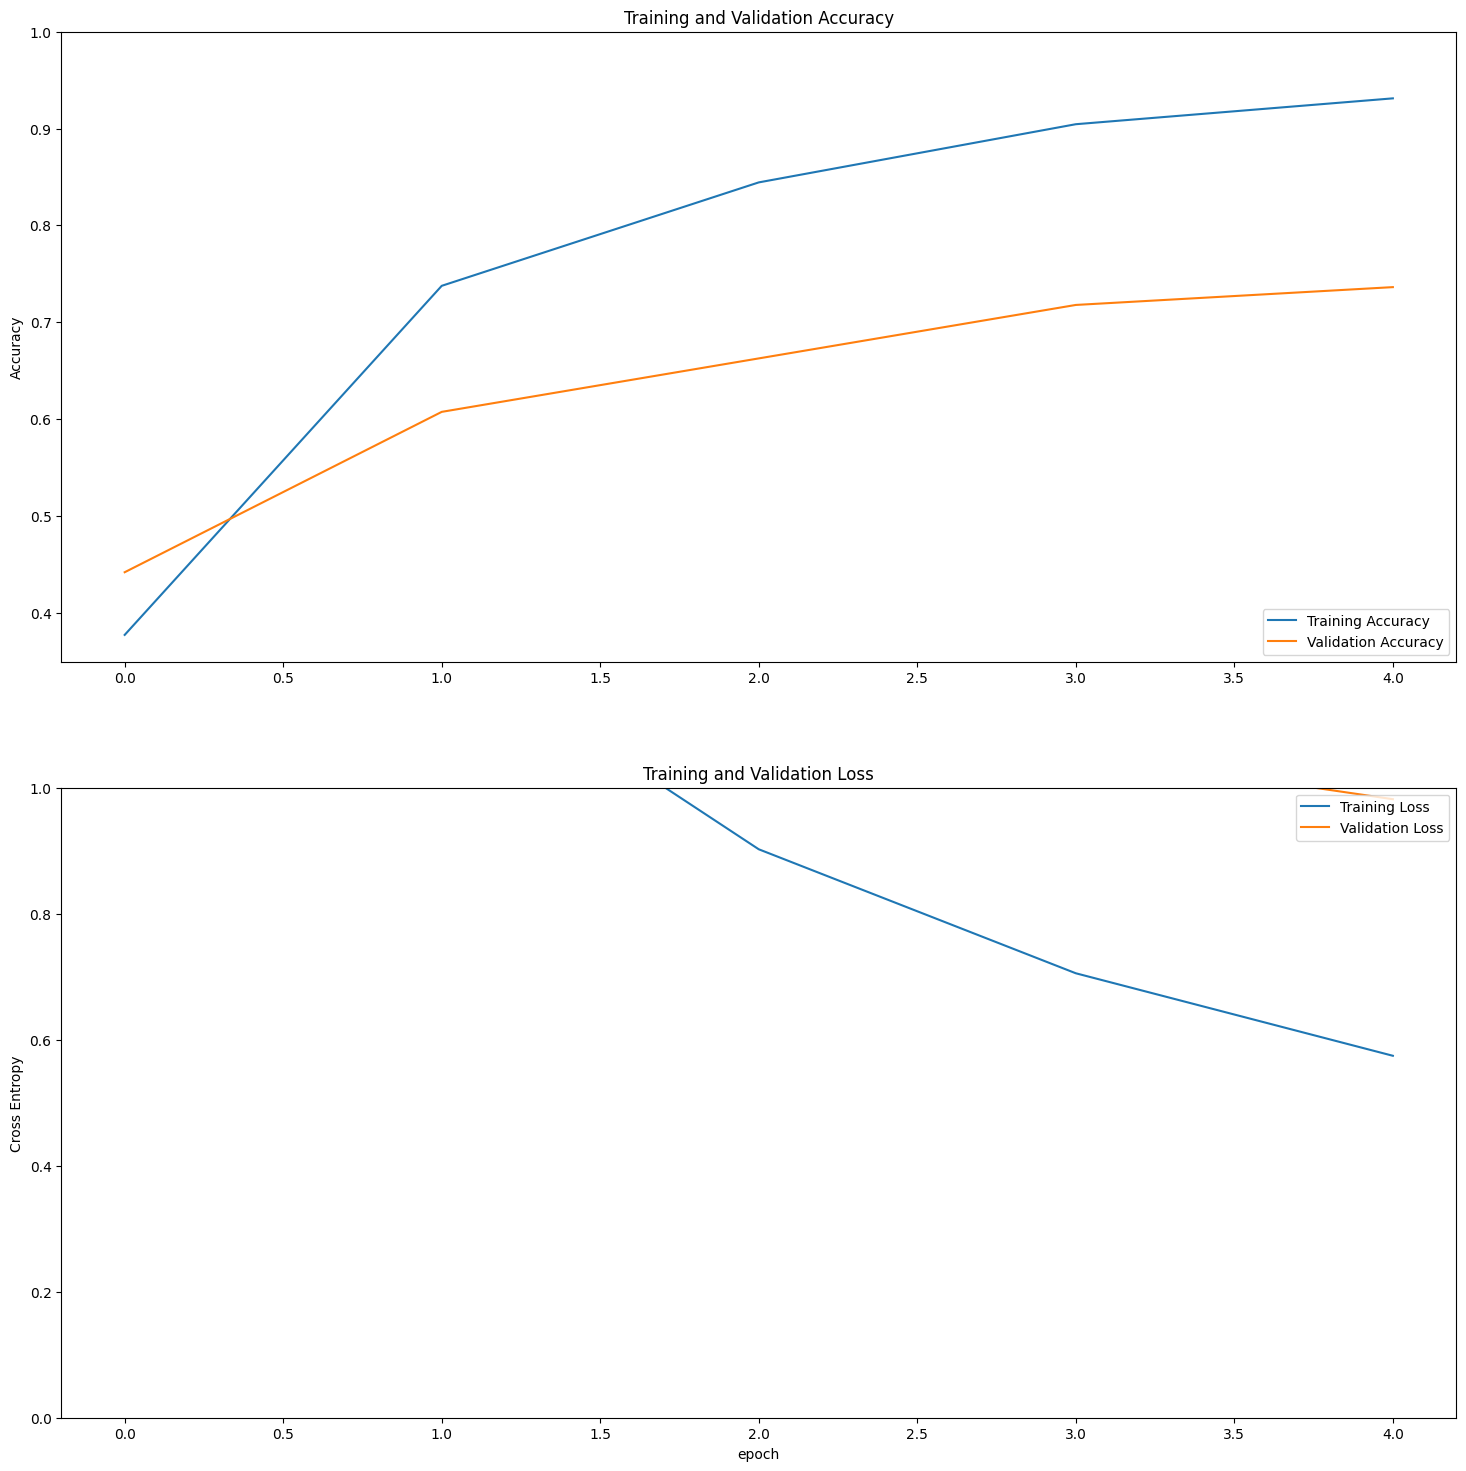

In [19]:
acc = history_of_model_1.history['accuracy']
val_acc = history_of_model_1.history['val_accuracy']

loss = history_of_model_1.history['loss']
val_loss = history_of_model_1.history['val_loss']

plt.figure(figsize=(18, 18))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Resultados

In [20]:
model.load_weights('./ModelCheckPoints/model_1.ckpt')


In [21]:
test_loss,test_acc=model.evaluate(test_data)

6/6 [==============================] - 0s 46ms/step - loss: 0.9818 - accuracy: 0.7362


In [22]:
text="<hr><span style='font-weight:bold; color:black'>"+f"Loss on Test Dataset: <b style='font-weight:bold; color:red'>{test_loss:.4f}</b>"+f"<br><br> Accuracy on Test Dataset: <b style='font-weight:bold; color:red'>{test_acc*100:.2f}%</b>"+"</span><hr>"
display(HTML(text))

## Fine-Tuning

Descongelar apenas as 10 top camadas.

In [23]:
# unfreezing the top 10 layers
model.layers[1].trainable=True
for layer in model.layers[1].layers[:-10]:
    layer.trainable=False

In [24]:
# checking the number of trainable layers in feature extraction model
len(model.layers[1].trainable_variables)

10

### Recompilando o modelo

- Por ser fine-tunning vou ajustar para uma menor taxa de aprendizado

In [25]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

### Treinando o modelo
- Usando 30 épocas

In [26]:
ModelCheckPoint_model_cb=create_model_check_point_callback('./ModelCheckPoints/model_2.ckpt')

# defining early stopping callback
early_stopping_cb=tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True,verbose=1)

# defining reduce learning rate on plateau callback
reduce_lr_cb=tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,patience=3,min_delta=1e-3,min_lr=1e-7,verbose=1)

fine_tune_epoch=30

history_of_model_2=model.fit(
    train_data,
    epochs=fine_tune_epoch,
    initial_epoch=EPOCHS-1,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[ModelCheckPoint_model_cb,early_stopping_cb,reduce_lr_cb, WandbCallback()]
)

Epoch 5/30
61/61 [==============================] - ETA: 0s - loss: 0.3025 - accuracy: 0.9404
Epoch 5: val_loss improved from inf to 0.58905, saving model to ./ModelCheckPoints/model_2.ckpt


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 52s 570ms/step - loss: 0.3025 - accuracy: 0.9404 - val_loss: 0.5890 - val_accuracy: 0.8160 - lr: 1.0000e-04
Epoch 6/30
60/61 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9766
Epoch 6: val_loss improved from 0.58905 to 0.49953, saving model to ./ModelCheckPoints/model_2.ckpt


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 33s 551ms/step - loss: 0.1314 - accuracy: 0.9769 - val_loss: 0.4995 - val_accuracy: 0.8098 - lr: 1.0000e-04
Epoch 7/30
60/61 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9922
Epoch 7: val_loss improved from 0.49953 to 0.48511, saving model to ./ModelCheckPoints/model_2.ckpt


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 32s 526ms/step - loss: 0.0761 - accuracy: 0.9923 - val_loss: 0.4851 - val_accuracy: 0.8405 - lr: 1.0000e-04
Epoch 8/30
60/61 [============================>.] - ETA: 0s - loss: 0.0463 - accuracy: 0.9979
Epoch 8: val_loss improved from 0.48511 to 0.44143, saving model to ./ModelCheckPoints/model_2.ckpt


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 33s 545ms/step - loss: 0.0462 - accuracy: 0.9979 - val_loss: 0.4414 - val_accuracy: 0.8405 - lr: 1.0000e-04
Epoch 9/30
60/61 [============================>.] - ETA: 0s - loss: 0.0323 - accuracy: 0.9995
Epoch 9: val_loss improved from 0.44143 to 0.43880, saving model to ./ModelCheckPoints/model_2.ckpt


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 33s 542ms/step - loss: 0.0321 - accuracy: 0.9995 - val_loss: 0.4388 - val_accuracy: 0.8466 - lr: 1.0000e-04
Epoch 10/30
60/61 [============================>.] - ETA: 0s - loss: 0.0220 - accuracy: 1.0000
Epoch 10: val_loss did not improve from 0.43880
61/61 [==============================] - 4s 57ms/step - loss: 0.0220 - accuracy: 1.0000 - val_loss: 0.4441 - val_accuracy: 0.8466 - lr: 1.0000e-04
Epoch 11/30
60/61 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 1.0000
Epoch 11: val_loss improved from 0.43880 to 0.42839, saving model to ./ModelCheckPoints/model_2.ckpt


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.2s


61/61 [==============================] - 31s 521ms/step - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.4284 - val_accuracy: 0.8405 - lr: 1.0000e-04
Epoch 12/30
60/61 [============================>.] - ETA: 0s - loss: 0.0123 - accuracy: 1.0000
Epoch 12: val_loss improved from 0.42839 to 0.42563, saving model to ./ModelCheckPoints/model_2.ckpt


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 32s 529ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.4256 - val_accuracy: 0.8466 - lr: 1.0000e-04
Epoch 13/30
60/61 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 1.0000
Epoch 13: val_loss improved from 0.42563 to 0.42320, saving model to ./ModelCheckPoints/model_2.ckpt


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 32s 522ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.4232 - val_accuracy: 0.8405 - lr: 1.0000e-04
Epoch 14/30
60/61 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 1.0000
Epoch 14: val_loss did not improve from 0.42320
61/61 [==============================] - 4s 57ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.4244 - val_accuracy: 0.8466 - lr: 1.0000e-04
Epoch 15/30
61/61 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 1.0000
Epoch 15: val_loss did not improve from 0.42320
61/61 [==============================] - 3s 51ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.4265 - val_accuracy: 0.8466 - lr: 1.0000e-04
Epoch 16/30
60/61 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000
Epoch 16: val_loss did not improve from 0.42320

Epoch 16: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
61/61 [==============================] - 4s 59ms/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 32s 525ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.4211 - val_accuracy: 0.8405 - lr: 2.0000e-05
Epoch 18/30
60/61 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000
Epoch 18: val_loss improved from 0.42114 to 0.42105, saving model to ./ModelCheckPoints/model_2.ckpt


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 32s 535ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.4210 - val_accuracy: 0.8466 - lr: 2.0000e-05
Epoch 19/30
61/61 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000
Epoch 19: val_loss improved from 0.42105 to 0.42061, saving model to ./ModelCheckPoints/model_2.ckpt


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 33s 537ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.4206 - val_accuracy: 0.8405 - lr: 2.0000e-05
Epoch 20/30
60/61 [============================>.] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000
Epoch 20: val_loss improved from 0.42061 to 0.42042, saving model to ./ModelCheckPoints/model_2.ckpt

Epoch 20: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231021_174156-buuhazik/files/model-best)... Done. 0.1s


61/61 [==============================] - 32s 524ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.4204 - val_accuracy: 0.8405 - lr: 2.0000e-05
Epoch 21/30
60/61 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000
Epoch 21: val_loss did not improve from 0.42042
61/61 [==============================] - 3s 52ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.4216 - val_accuracy: 0.8405 - lr: 4.0000e-06
Epoch 22/30
60/61 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000
Epoch 22: val_loss did not improve from 0.42042
61/61 [==============================] - 3s 53ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.4216 - val_accuracy: 0.8466 - lr: 4.0000e-06
Epoch 23/30
61/61 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000
Epoch 23: val_loss did not improve from 0.42042

Epoch 23: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
61/61 [==============================] - 4s 57ms/s

### Curvas de Aprendizado

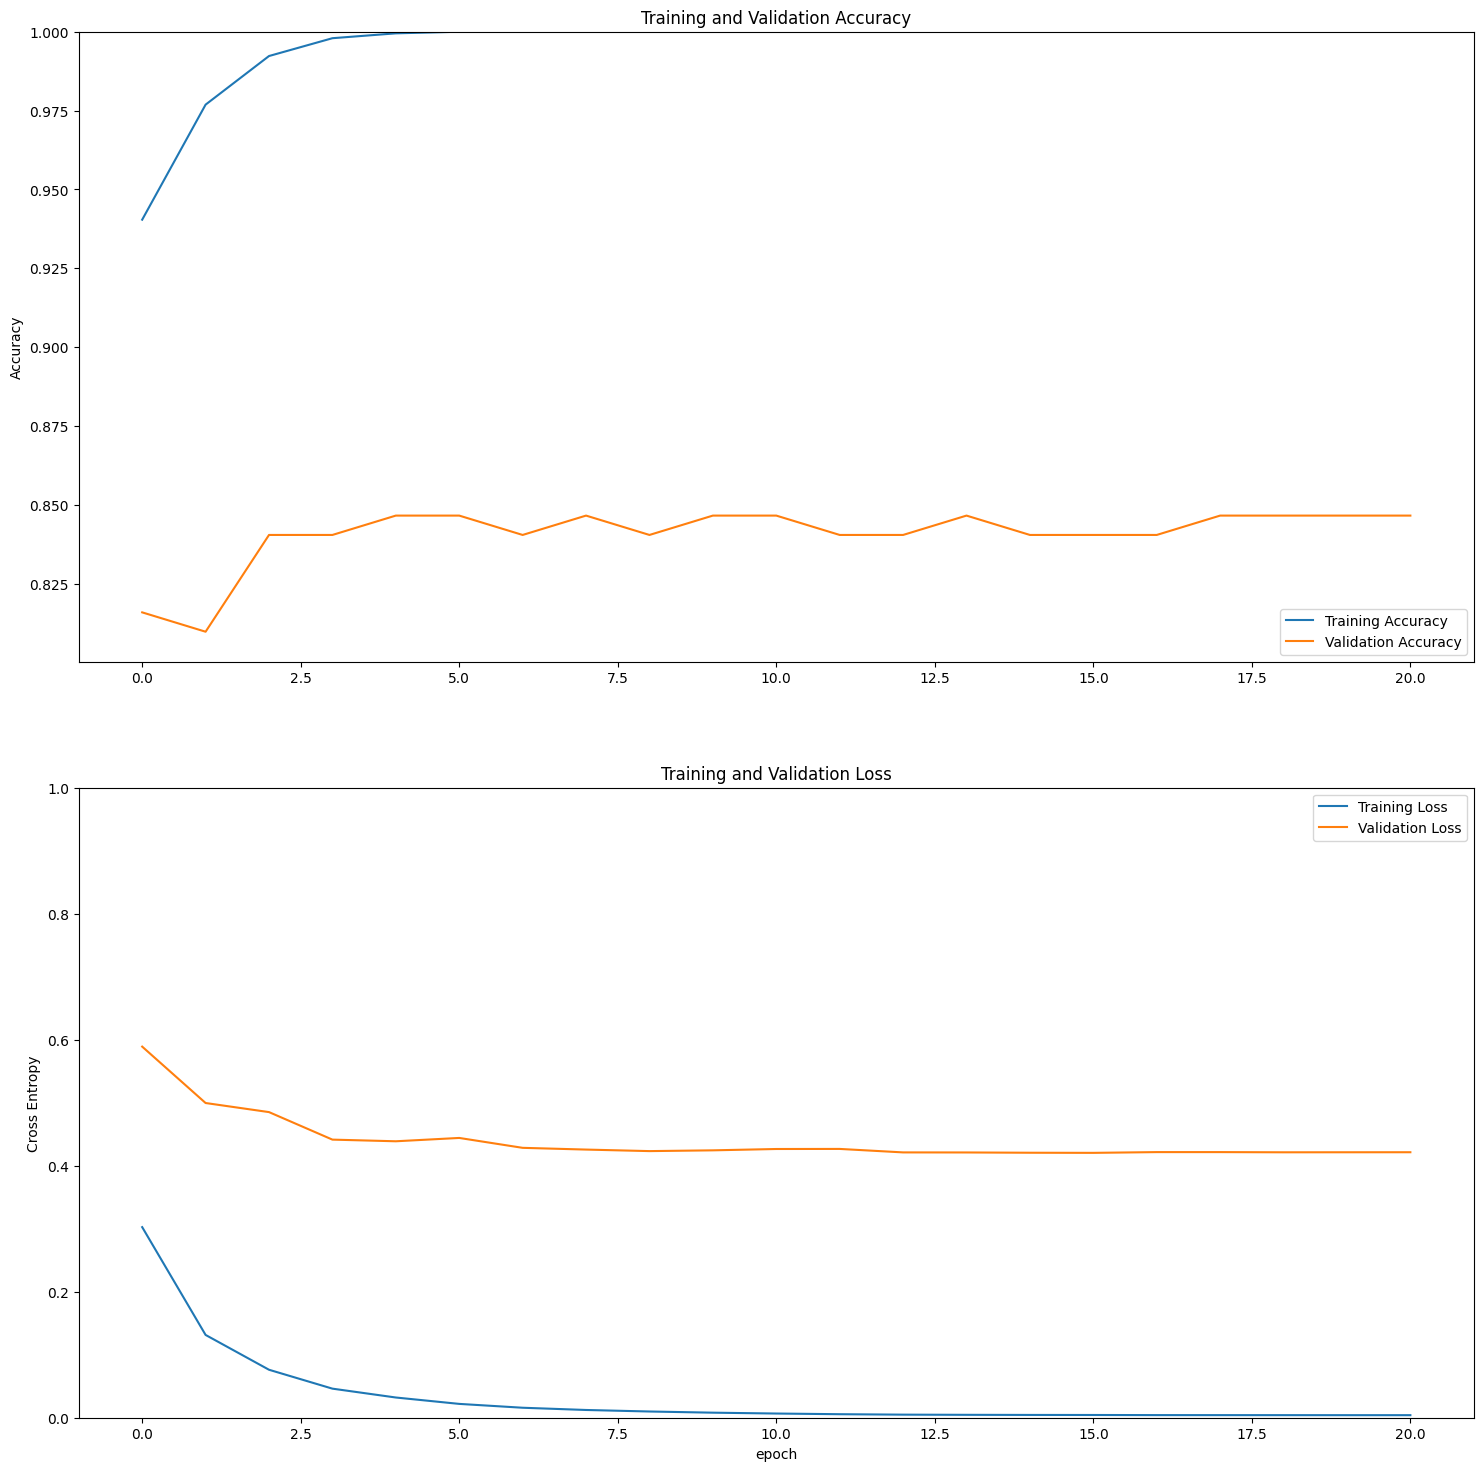

In [27]:
acc = history_of_model_2.history['accuracy']
val_acc = history_of_model_2.history['val_accuracy']

loss = history_of_model_2.history['loss']
val_loss = history_of_model_2.history['val_loss']

plt.figure(figsize=(18, 18))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Resultados

In [28]:
model.load_weights('./ModelCheckPoints/model_2.ckpt')


In [29]:
test_loss,test_acc=model.evaluate(test_data)

6/6 [==============================] - 0s 48ms/step - loss: 0.4204 - accuracy: 0.8405


In [30]:
text="<hr><span style='font-weight:bold; color:black'>"+f"Loss on Test Dataset: <b style='font-weight:bold; color:red'>{test_loss:.4f}</b>"+f"<br><br> Accuracy on Test Dataset: <b style='font-weight:bold; color:red'>{test_acc*100:.2f}%</b>"+"</span><hr>"
display(HTML(text))

## Análise de Resultado final

In [31]:
def plot_and_compare_history(original_history,new_history,initial_epoch):
    display(HTML("<h3 style='text-align:center; font-weight:bold; color:red'> Impact of Fine tunning on Performance Curves</h3><hr>"))
    #get original history measurements
    acc=original_history.history['accuracy']
    loss=original_history.history['loss']
    val_acc=original_history.history['val_accuracy']
    val_loss=original_history.history['val_loss']

    #combining
    total_acc=acc+new_history.history['accuracy']
    total_loss=loss+new_history.history['loss']
    total_val_acc=val_acc+new_history.history['val_accuracy']
    total_val_loss=val_loss+new_history.history['val_loss']

    #make plots
    plt.figure(figsize=(24,8))
    plt.subplot(1,2,1)
    plt.plot(total_acc,label='Training Accuracy')
    plt.plot(total_val_acc,label='Validation Accuracy')
    plt.plot([initial_epoch-1,initial_epoch-1],plt.ylim(),label='Start fine tunning')
    plt.title("Accuracy",size=20)
    plt.xlabel("Epochs",size=15)
    plt.ylabel("Loss",size=15)
    plt.legend(loc='lower right')
    plt.subplot(1,2,2)
    plt.plot(total_loss,label='Training loss')
    plt.plot(total_val_loss,label="Validation loss")
    plt.plot([initial_epoch-1,initial_epoch-1],plt.ylim(),label='Start fine tunning')
    plt.title("Loss",size=20)
    plt.ylabel('Accuracy',size=15)
    plt.xlabel("Epochs",size=15)
    plt.legend(loc="upper right")
    plt.tight_layout();

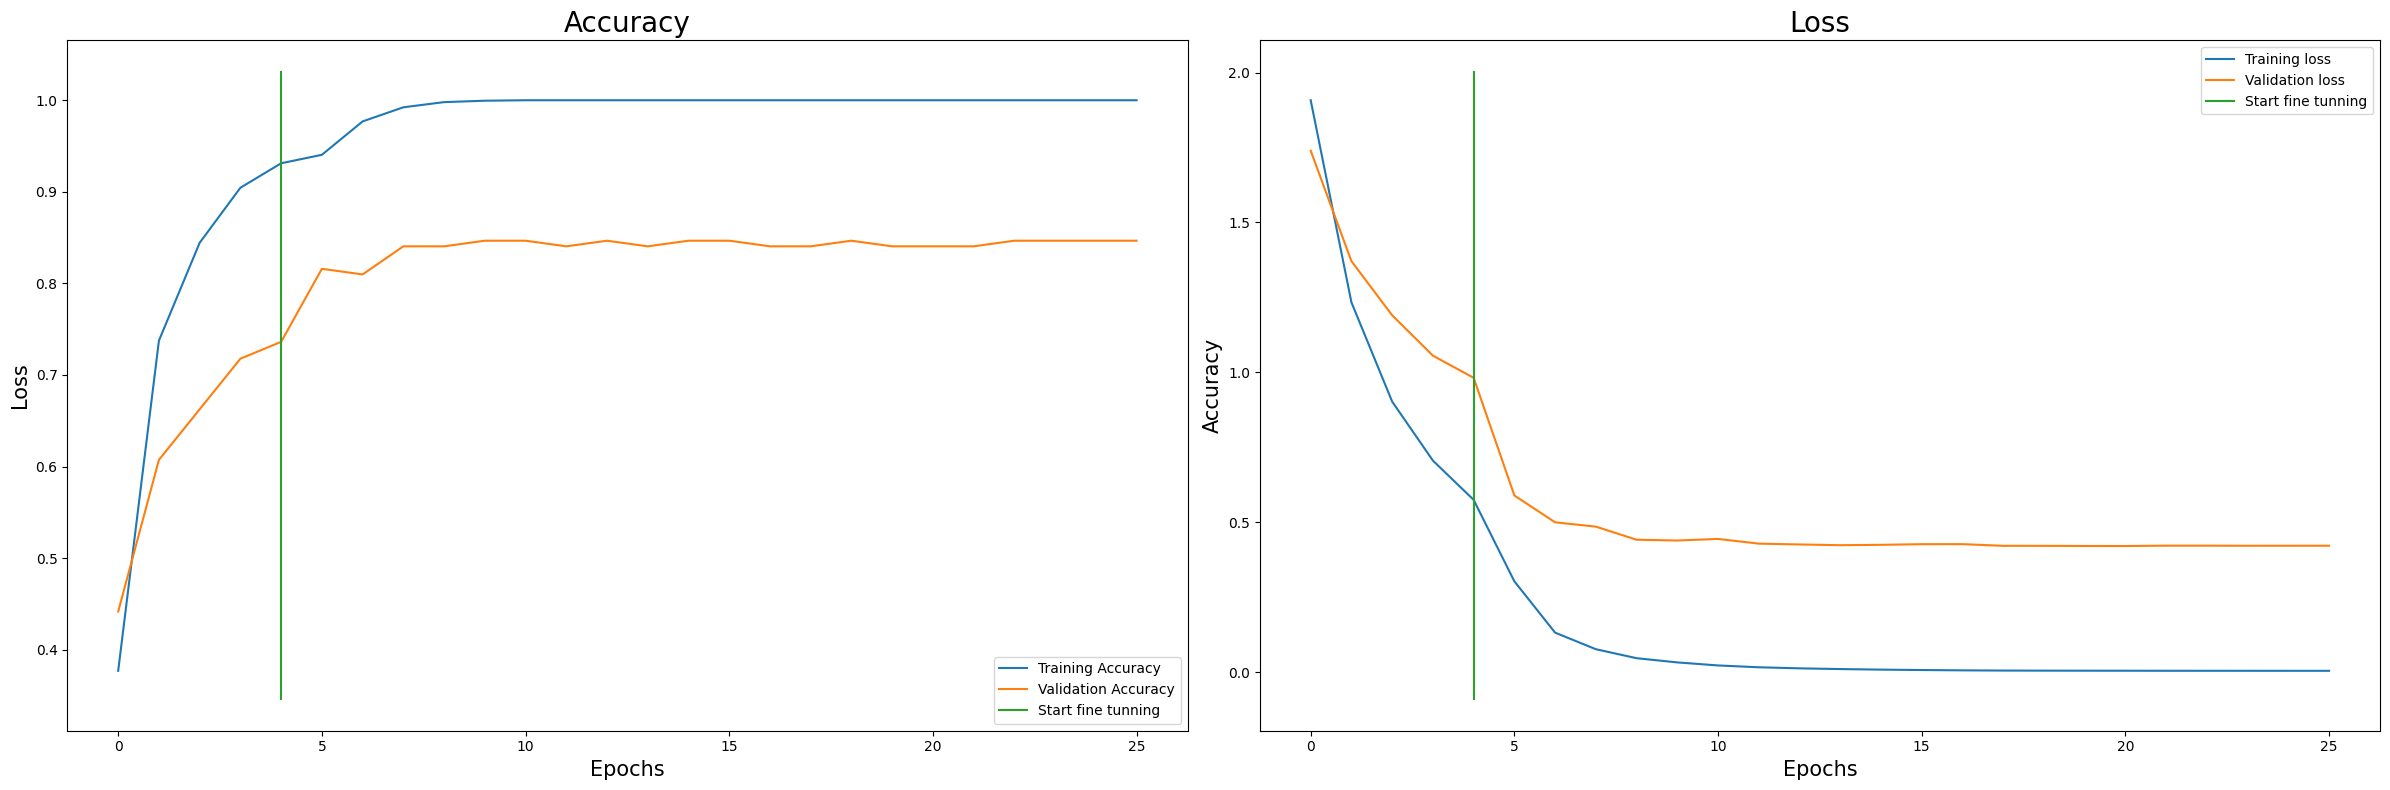

In [32]:
plot_and_compare_history(history_of_model_1,history_of_model_2,initial_epoch=5)

In [33]:
 wandb.join()


#### Save the model

In [38]:
wandb.init(project='f1-classification', job_type='producer')

artifact = wandb.Artifact('model', type='model')

artifact.add_file('/content/wandb/run-20231021_174156-buuhazik/files/model-best.h5')

wandb.log_artifact(artifact)
wandb.join()

## TESTES REAIS

In [39]:
# make predictions on the test data
pred_proba=model.predict(test_data)
pred_proba[:2]

6/6 [==============================] - 2s 50ms/step


array([[9.98768032e-01, 1.35694665e-06, 4.00535850e-04, 2.18847572e-06,
        5.70215934e-06, 6.27259360e-05, 1.33295669e-06, 5.01531872e-07,
        7.03165133e-04, 5.45535622e-05],
       [8.67839336e-01, 3.88239650e-03, 1.15336105e-02, 6.63578063e-02,
        2.44191336e-03, 1.56986099e-02, 1.22350757e-03, 2.07866896e-02,
        2.44282623e-04, 9.99179389e-03]], dtype=float32)

In [40]:
len(pred_proba)

163

In [41]:
# converting the prediction probabilities to class number
pred_class_number=tf.argmax(pred_proba,axis=1)
pred_class_number[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 5, 0])>

In [48]:
len(pred_class_number)

163

In [42]:
# true labels
y_labels=[]
for _,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())

y_labels[:5]

[0, 0, 0, 0, 0]

In [43]:
len(y_labels)

163

In [44]:
class_names[:5]


['alfaromeo', 'alphatauri', 'alpine', 'astonmartin', 'ferrari']

In [49]:
# Step 1
test_image_batches = []
for images, labels in test_data.take(-1):
    test_image_batches.append(images.numpy())

# Step 2
test_images = [item for sublist in test_image_batches for item in sublist]
len(test_images)

163

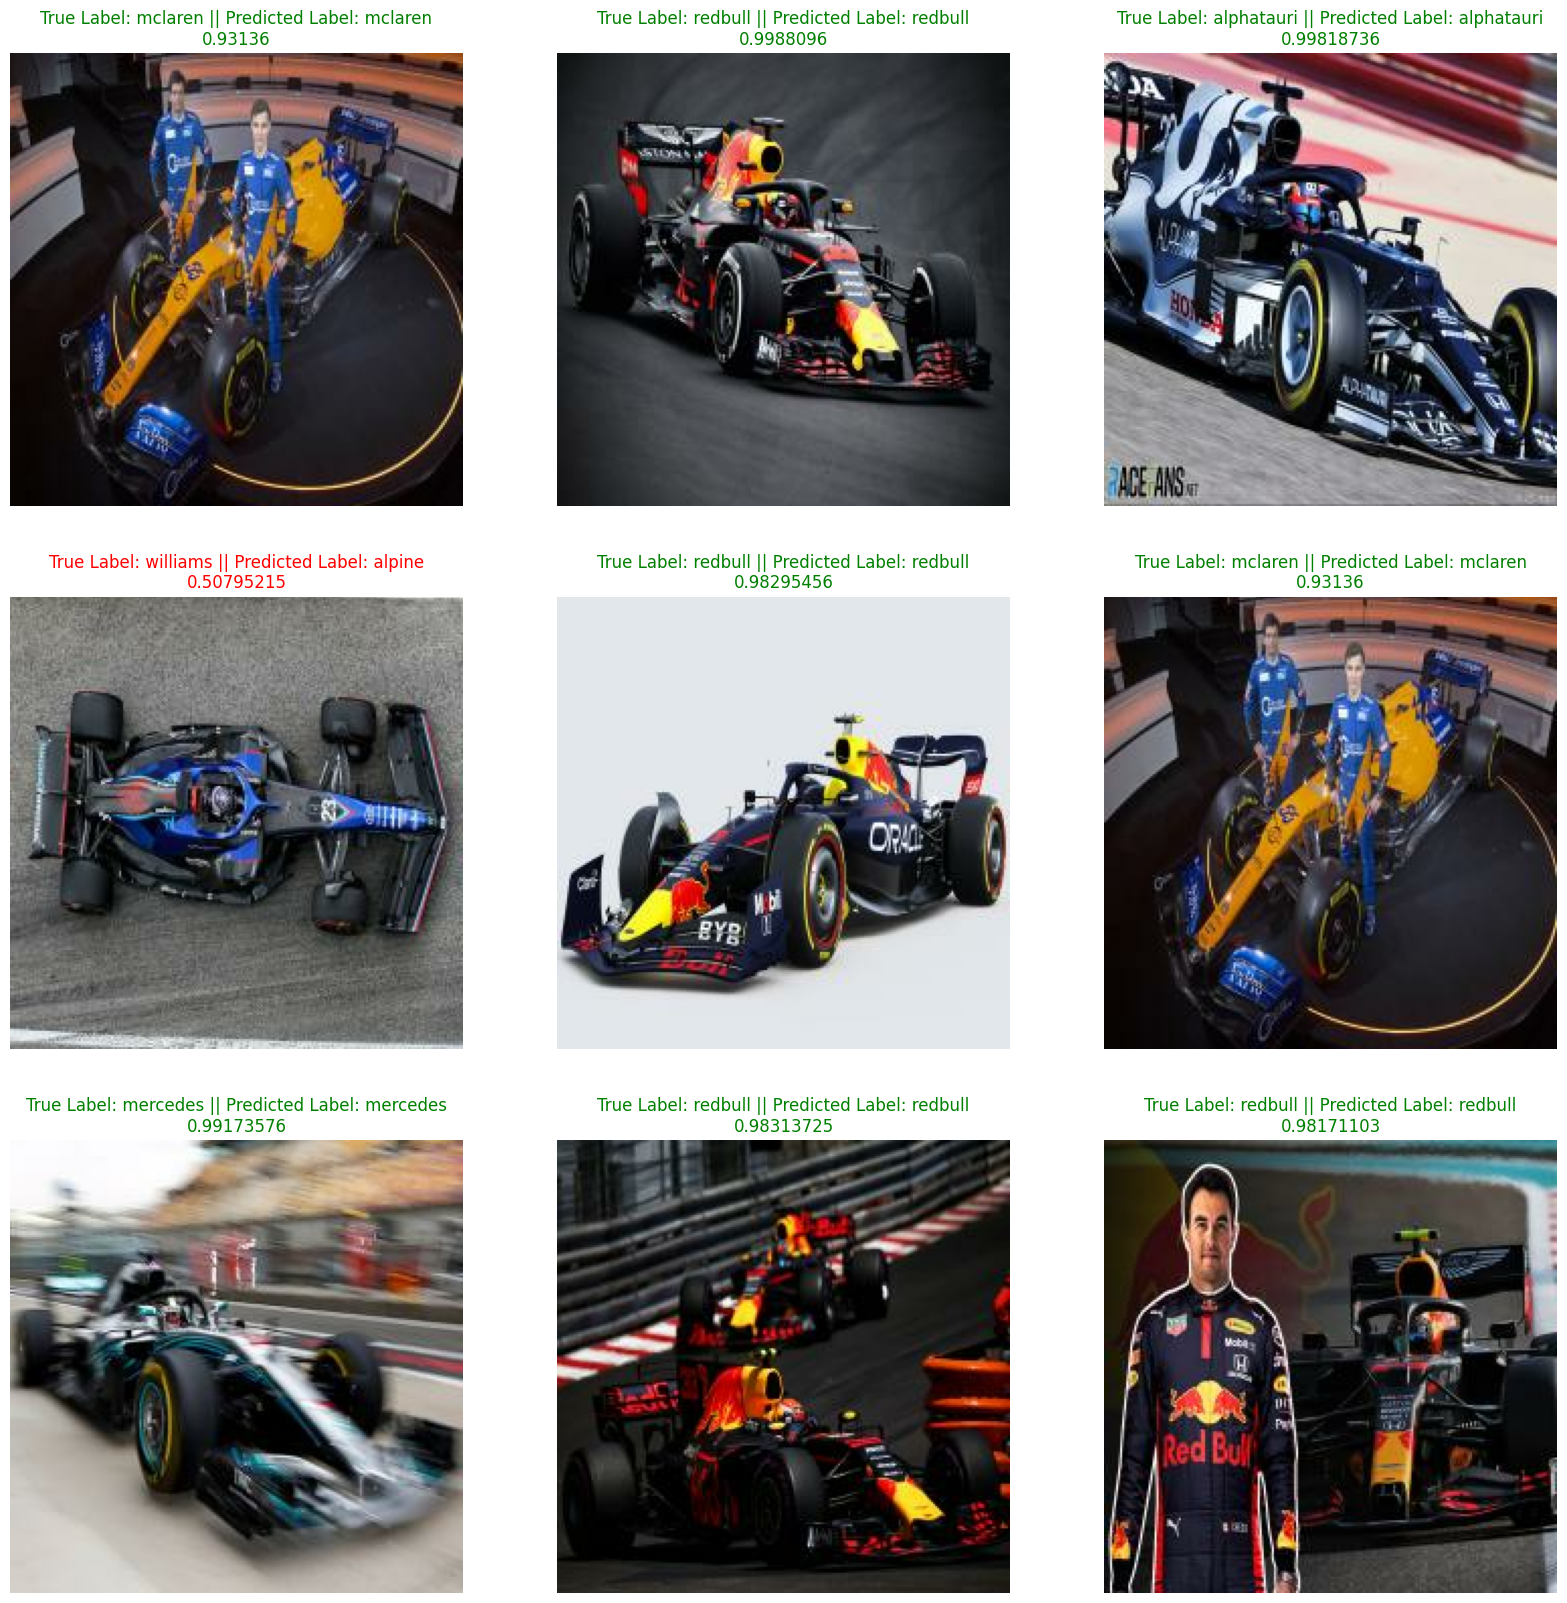

In [50]:
plt.figure(figsize = (20,20))
for i in range(9):
    random_int_index = random.choice(range(len(test_images)))
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[random_int_index]/255.)
    if y_labels[random_int_index] == pred_class_number[random_int_index]:
        color = "g"
    else:
        color = "r"
    plt.title("True Label: " + class_names[y_labels[random_int_index]] + " || " + "Predicted Label: " +
              class_names[pred_class_number[random_int_index]] + "\n" +
              str(np.asarray(tf.reduce_max(pred_proba, axis = 1))[random_int_index]), c=color)
    plt.axis(False);

### Matriz de Confusão

In [57]:
def make_confusion_matrix(y_true,y_preds,class_names):

    cm=confusion_matrix(y_true,y_preds)
    plt.figure(figsize=(14,10))
    sns.heatmap(cm,annot=True,cmap='Blues',fmt='.0f')
    display(HTML("<h2 style='font-weight:bold; color:#3498DB; text-align:center;'>Confusion Matrix</h2><hr>"))
    plt.ylabel("True values",size=15)
    plt.xlabel('Predicted values',size=15)
    plt.xticks(ticks=np.arange(len(class_names))+0.5,labels=class_names,rotation=60)
    plt.yticks(ticks=np.arange(len(class_names))+0.5,labels=class_names,rotation=0)

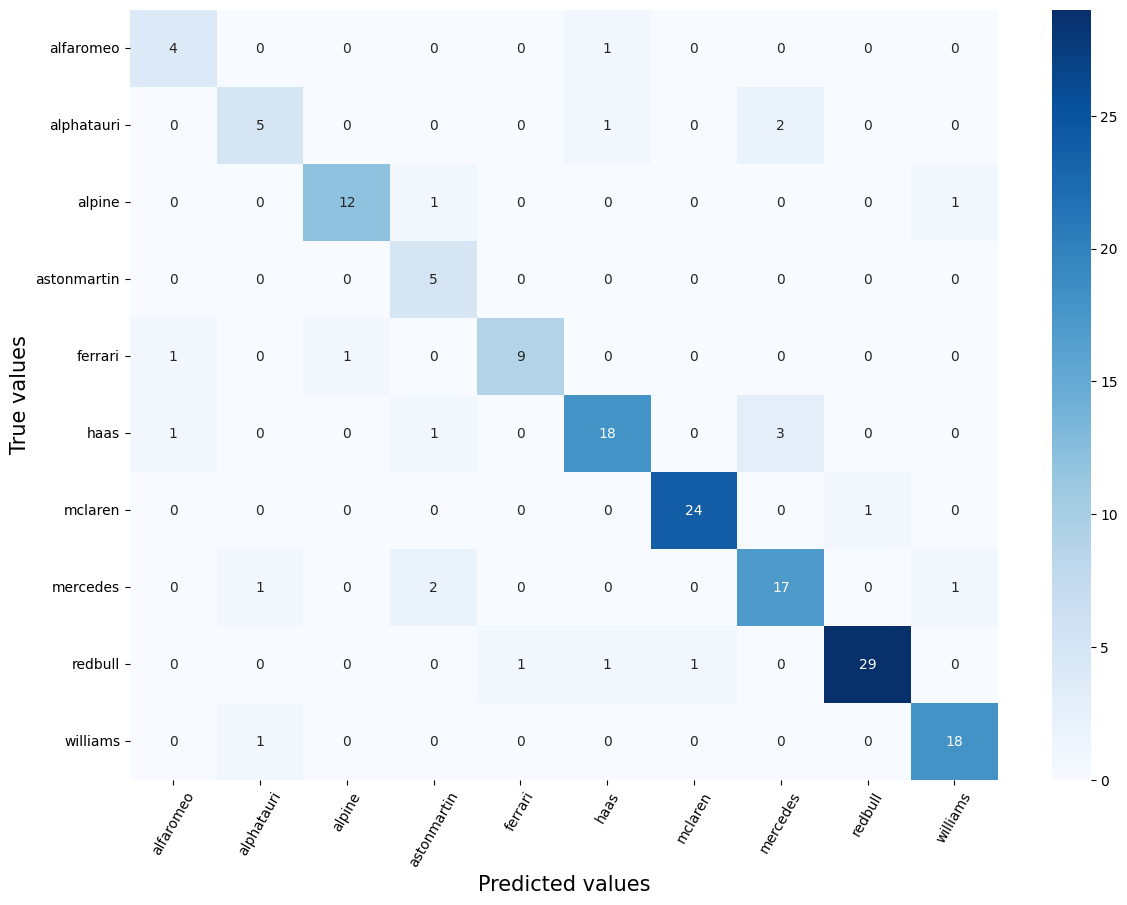

In [58]:
make_confusion_matrix(y_labels,pred_class_number,class_names)

### Métricas

In [51]:
from sklearn.metrics import classification_report
report = classification_report(y_labels, pred_class_number, output_dict=True)

#check a small slice of the dictionary
import itertools
dict(itertools.islice(report.items(), 3))

{'0': {'precision': 0.8,
  'recall': 0.8,
  'f1-score': 0.8000000000000002,
  'support': 5},
 '1': {'precision': 0.625, 'recall': 0.625, 'f1-score': 0.625, 'support': 8},
 '2': {'precision': 0.8571428571428571,
  'recall': 0.8571428571428571,
  'f1-score': 0.8571428571428571,
  'support': 14}}

In [52]:
f1scores = {}
for k,v in report.items():
    if k == 'accuracy':
        break
    else:
        f1scores[class_names[int(k)]] = v['f1-score']

#check a small slice of the dictionary
dict(itertools.islice(f1scores.items(), 5))

{'alfaromeo': 0.8000000000000002,
 'alphatauri': 0.625,
 'alpine': 0.8571428571428571,
 'astonmartin': 0.625,
 'ferrari': 0.9166666666666666}

Checando as métricas por classe F1-Score

In [53]:
F1 = pd.DataFrame({"Classes":list(f1scores.keys()),
                   "F1-Scores":list(f1scores.values())}).sort_values("F1-Scores", ascending=False)

#check a small slice of the dataframe
F1[:10]

Classes  F1-Scores
6      mclaren   0.960000
8      redbull   0.918033
4      ferrari   0.916667
2       alpine   0.857143
9     williams   0.823529
0    alfaromeo   0.800000
5         haas   0.790698
7     mercedes   0.772727
1   alphatauri   0.625000
3  astonmartin   0.625000

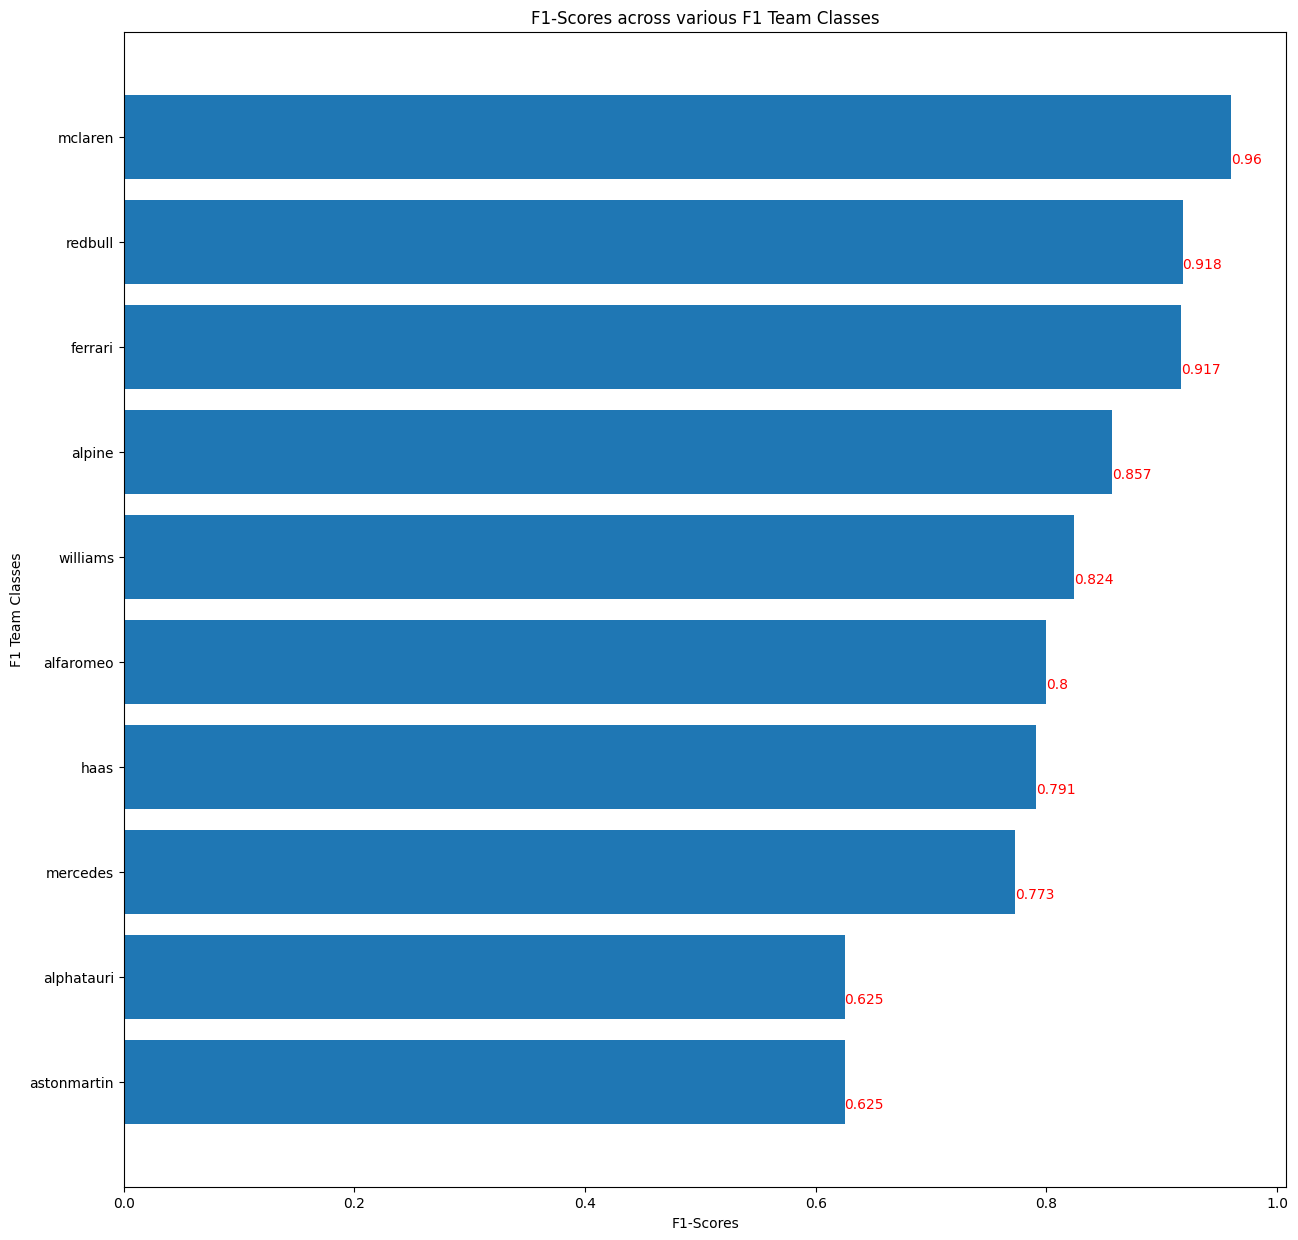

In [59]:
fig, ax = plt.subplots(figsize = (15,15))
plt.barh(F1["Classes"], F1["F1-Scores"])
plt.ylim(-1,10)
plt.xlabel("F1-Scores")
plt.ylabel("F1 Team Classes")
plt.title("F1-Scores across various F1 Team Classes")
plt.gca().invert_yaxis()
for i, v in enumerate(round(F1["F1-Scores"],3)):
    ax.text(v, i + .25, str(v), color='red');

In [62]:
predictions = pd.DataFrame({"Image Index" : list(range(len(test_images))),
                            "Test Labels" : list(y_labels),
                            "Test Classes" : [class_names[i] for i in y_labels],
                            "Prediction Labels" : list(np.asarray(pred_class_number)),
                            "Prediction Classes" : [class_names[i] for i in pred_class_number],
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(pred_proba, axis = 1))]})

predictions

Image Index  Test Labels Test Classes  Prediction Labels  \
0              0            0    alfaromeo                  0   
1              1            0    alfaromeo                  0   
2              2            0    alfaromeo                  0   
3              3            0    alfaromeo                  5   
4              4            0    alfaromeo                  0   
..           ...          ...          ...                ...   
158          158            9     williams                  9   
159          159            9     williams                  9   
160          160            9     williams                  9   
161          161            9     williams                  9   
162          162            9     williams                  2   

    Prediction Classes  Prediction Probability  
0            alfaromeo                0.998768  
1            alfaromeo                0.867839  
2            alfaromeo                0.998212  
3                 haas                0.937397  
4            alfaromeo                0.995834  
..                 ...                     ...  
158           williams                0.986636  
159           williams                0.753032  
160           williams                0.595807  
161           williams                0.982217  
162             alpine                0.548284  

[163 rows x 6 columns]

In [63]:
predictions["Correct Prediction"] = predictions["Test Labels"] == predictions["Prediction Labels"]
predictions[:10]

Image Index  Test Labels Test Classes  Prediction Labels  \
0            0            0    alfaromeo                  0   
1            1            0    alfaromeo                  0   
2            2            0    alfaromeo                  0   
3            3            0    alfaromeo                  5   
4            4            0    alfaromeo                  0   
5            5            1   alphatauri                  1   
6            6            1   alphatauri                  1   
7            7            1   alphatauri                  1   
8            8            1   alphatauri                  1   
9            9            1   alphatauri                  7   

  Prediction Classes  Prediction Probability  Correct Prediction  
0          alfaromeo                0.998768                True  
1          alfaromeo                0.867839                True  
2          alfaromeo                0.998212                True  
3               haas                0.937397               False  
4          alfaromeo                0.995834                True  
5         alphatauri                0.701543                True  
6         alphatauri                0.998187                True  
7         alphatauri                0.726819                True  
8         alphatauri                0.979472                True  
9           mercedes                0.399502               False

In [64]:
predictions = predictions[predictions["Correct Prediction"] == False].sort_values("Prediction Probability", ascending=False)
predictions[:10]

Image Index  Test Labels Test Classes  Prediction Labels  \
118          118            8      redbull                  5   
97            97            7     mercedes                  3   
10            10            1   alphatauri                  7   
3              3            0    alfaromeo                  5   
95            95            7     mercedes                  1   
12            12            1   alphatauri                  7   
101          101            7     mercedes                  9   
134          134            8      redbull                  6   
133          133            8      redbull                  4   
70            70            6      mclaren                  8   

    Prediction Classes  Prediction Probability  Correct Prediction  
118               haas                0.959617               False  
97         astonmartin                0.943901               False  
10            mercedes                0.939922               False  
3                 haas                0.937397               False  
95          alphatauri                0.929166               False  
12            mercedes                0.813500               False  
101           williams                0.787732               False  
134            mclaren                0.773740               False  
133            ferrari                0.689795               False  
70             redbull                0.682138               False

### Top 10 wrong probably predicted incorrectly.


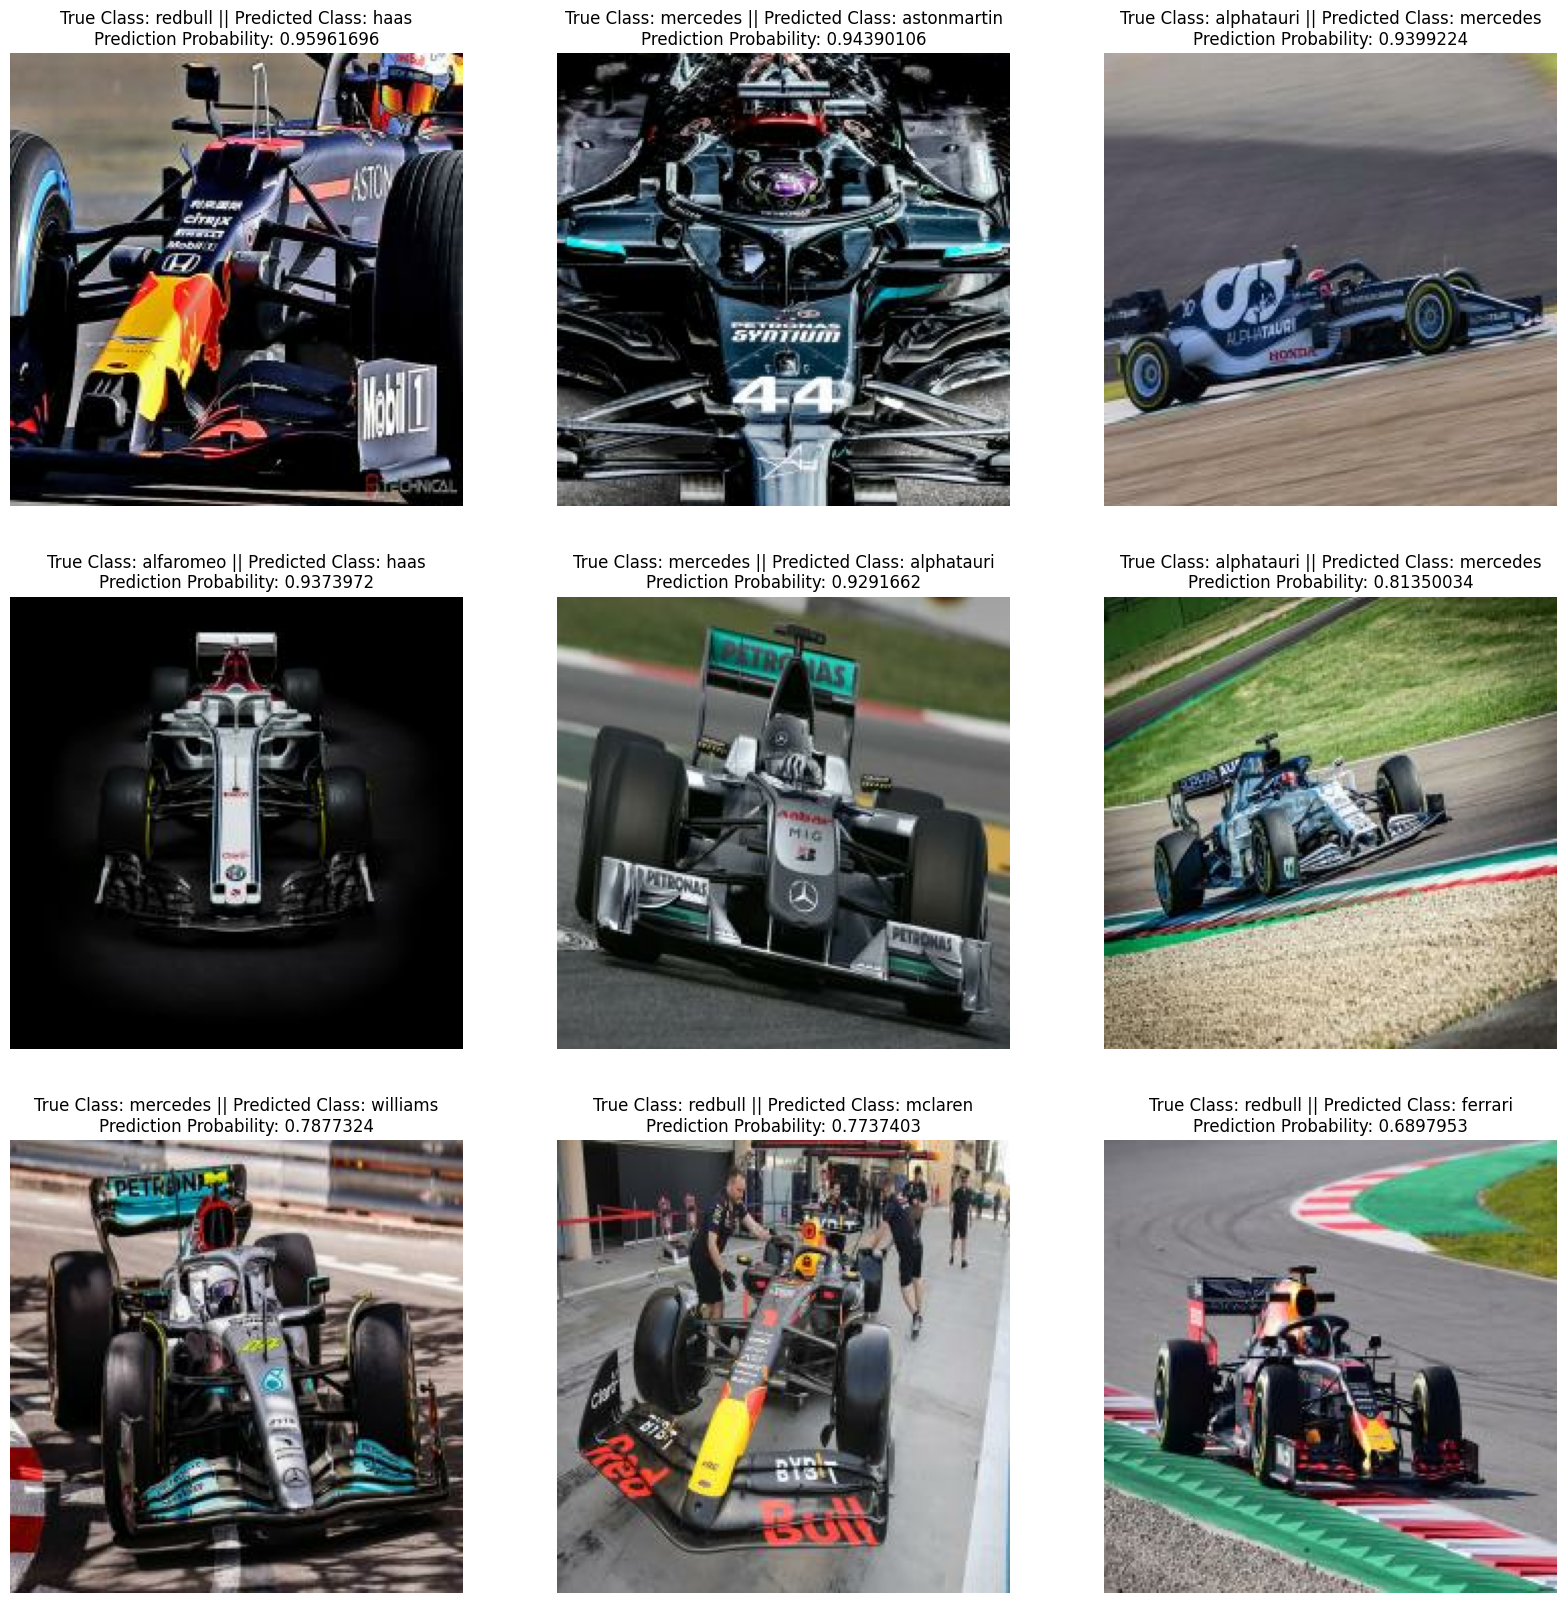

In [65]:
indexes = np.asarray(predictions["Image Index"][:9]) #choosing the top 9 records from the dataframe
plt.figure(figsize=(20,20))
for i, x in enumerate(indexes):
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[x]/255)
    plt.title("True Class: " + class_names[y_labels[x]] + " || " + "Predicted Class: " + class_names[pred_class_number[x]] + "\n" +
             "Prediction Probability: " + str(np.asarray(tf.reduce_max(pred_proba, axis = 1))[x]))
    plt.axis(False);

## Conclusões


- A base de dados de imagens manualmente selecionadas necessitou processo de augumentation, isto é acrescentar novas imagens por processamento de imagens como rotação, saturação, redimensionamento de imagem. Todo este processo está documentado aqui: https://universe.roboflow.com/corriporai/f1-car-teams


- Utilizei por fins didáticos a rede neural EfficientNet B0. Não pude em tempo hábil testar outros tipos de redes neurais como MobileNet, VGG, ResNet.


- Utilizei a abordagem de feature extraction e fine-tunning, como alguns callbacks que li em documentação e exemplos para parada antecipada se não houver melhora na acurácia e loss da validação. Utilizei também a técnica de redução do learning rate a medida que o modelo começa a estagnar nos erros de validação/treinamento.


- Em relação ao problema, o modelo conseguiu um resultado interessante de 84.6% de acurácia. O modelo teve bons resultados para os times da ferrari, redbull e mclaren. Infiro que pelas cores dos carros e patrocinadores que são bem contrastantes. Todavia para os carros da alphatauri, astonmartin e mercedes foram que tiveram o pior f1-score. São carros que em exemplos realmente se confundem pois são carros que tem cores e contrastes bem similares. Outra dificuldade posta foi também as imagens utilizadas em testes. Alguns carros só tinham parte do veículo, outras com carros mais próximos e outros com carros com fotos tiradas mais distantes. Com a perda de resolução adicionada ao reduzir as imagens para 240x240 (exigência do EfficientNetB0), pode ter uma perda associada na predição de times de formula 1.

In [67]:
!zip -r /content/wandb_data.zip /content/wandb

  adding: content/wandb/ (stored 0%)
  adding: content/wandb/debug.log (deflated 77%)
  adding: content/wandb/run-20231021_180432-ur3nq3vy/ (stored 0%)
  adding: content/wandb/run-20231021_180432-ur3nq3vy/run-ur3nq3vy.wandb (deflated 44%)
  adding: content/wandb/run-20231021_180432-ur3nq3vy/tmp/ (stored 0%)
  adding: content/wandb/run-20231021_180432-ur3nq3vy/tmp/code/ (stored 0%)
  adding: content/wandb/run-20231021_180432-ur3nq3vy/files/ (stored 0%)
  adding: content/wandb/run-20231021_180432-ur3nq3vy/files/requirements.txt (deflated 55%)
  adding: content/wandb/run-20231021_180432-ur3nq3vy/files/config.yaml (deflated 58%)
  adding: content/wandb/run-20231021_180432-ur3nq3vy/files/wandb-summary.json (stored 0%)
  adding: content/wandb/run-20231021_180432-ur3nq3vy/files/wandb-metadata.json (deflated 60%)
  adding: content/wandb/run-20231021_180432-ur3nq3vy/logs/ (stored 0%)
  adding: content/wandb/run-20231021_180432-ur3nq3vy/logs/debug.log (deflated 77%)
  adding: content/wandb/run-2

In [70]:
#export your model's weights for future use
from google.colab import files
files.download('/content/wandb/run-20231021_174156-buuhazik/files/model-best.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>